# House Price Code

## Imports and Load Data

In [1]:
#Imports
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [2]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [3]:
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])

## Clean Data

In [4]:
# From the data description, when these values are nan, the property does not contain installment. 
# So we will change these features from nan to None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [5]:
# Check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [6]:
def clean_df(df):
    
    for col in df.columns:
        
        # Replace the missing value to None if feature is in the na_none list
        if col in na_none:
            df[col] =  df[col].fillna('None')
        
        # Drop features that contain more than 20% missing values
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
            
    return df

In [7]:
df_cleaned = clean_df(df_raw) # drop columns and replace nan with none

df_cleaned = df_cleaned.dropna() #drop any row with missing data

In [8]:
#Drop ID column
df_cleaned = df_cleaned.drop('Id', axis=1)

# split train dataset
df_x = df_cleaned.drop(columns='SalePrice')
df_y = df_cleaned['SalePrice']

df_x.shape

(2726, 78)

In [9]:
df_cleaned

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,2,2008,WD,Normal,208500.000000
1,20,RL,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,5,2007,WD,Normal,181500.000000
2,60,RL,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2008,WD,Normal,223500.000000
3,70,RL,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.000000
4,60,RL,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,RL,13384,Pave,None,Reg,Lvl,AllPub,Inside,Mod,...,0,None,None,None,0,5,2006,WD,Normal,188506.431412
1452,160,RM,1533,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,12,2006,WD,Abnorml,172917.456816
1455,160,RM,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,4,2006,WD,Abnorml,164788.778231
1456,20,RL,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2006,WD,Abnorml,219222.423400


## Encode Data

In [10]:
#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

In [12]:
df_x_encoded

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,188216.590793,8450,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,2,2008,178231.141232,178717.795783
1,20,188216.590793,9600,1,1,1,1,1,181436.760833,1,...,0,0,1,1,1,0,5,2007,178231.141232,178717.795783
2,60,188216.590793,11250,1,1,2,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2008,178231.141232,178717.795783
3,70,188216.590793,9550,1,1,2,1,1,182996.979724,1,...,0,0,1,1,1,0,2,2006,178231.141232,165527.980749
4,60,188216.590793,14260,1,1,2,1,1,181436.760833,1,...,0,0,1,1,1,0,12,2008,178231.141232,178717.795783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,188216.590793,13384,1,1,1,1,1,179629.124775,2,...,0,0,1,1,1,0,5,2006,178231.141232,178717.795783
1452,160,151286.299685,1533,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,12,2006,178231.141232,165527.980749
1455,160,151286.299685,1894,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,4,2006,178231.141232,165527.980749
1456,20,188216.590793,20000,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2006,178231.141232,165527.980749


## Sort, Split and Scale Data

In [13]:
# Sort Data Chronologically (preventing data leakage)
df_x_encoded = df_x_encoded.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

# Sort df_x_encoded by YearSold
df_x_sorted = df_x_encoded.sort_values(by='YrSold')

# Set the index of df_y to match the sorted index of df_x_sorted
df_y_sorted = df_y.loc[df_x_sorted.index]

In [14]:
# Split Data into Dev and Test
X_dev, X_test, y_dev, y_test = train_test_split(df_x_sorted, df_y_sorted, test_size=0.2, shuffle=False)

# Split Dev into Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, shuffle=False)

In [15]:
#Scale Data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_val_scaled = scale.transform(X_val)
X_test_scaled = scale.fit_transform(X_test)

## PCA

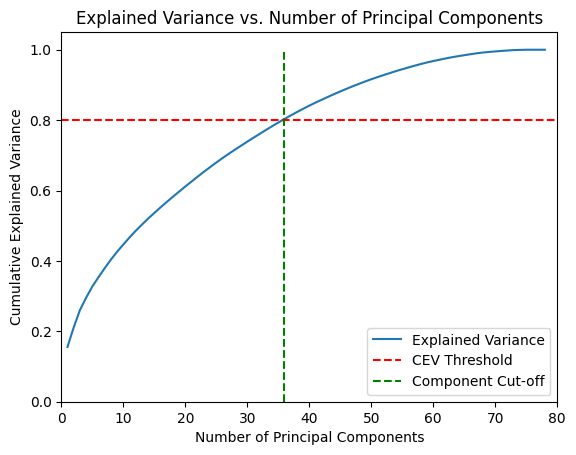

In [16]:
from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=36, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [17]:
#Determine the number of PCA that explain a sufficient proportion of the variance
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [18]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_val_pca = pca_optimal.fit_transform(X_val_scaled)
X_test_pca = pca_optimal.fit_transform(X_test_scaled)

In [19]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(X_train_pca, columns=['PC' + str(i + 1) for i in range(n_components)])
df_principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,2.434796,0.679369,1.674521,-1.012650,1.043933,0.960706,-1.256223,-1.138269,0.630585,1.158905,...,0.058582,-1.015284,0.216984,0.466548,-0.773796,-0.665896,0.170051,0.427852,-1.150914,-0.027877
1,-3.282257,-0.558346,-1.478765,-0.951398,-0.560190,2.759153,0.581298,0.673826,-0.189789,0.885754,...,-1.019620,0.373978,0.879528,-1.891675,-0.619636,-0.431120,0.634139,-1.537435,-0.013399,-0.851230
2,3.240689,-1.633821,1.900868,-1.644159,0.142550,-0.067279,0.030077,-0.196096,0.168611,-0.377204,...,0.579258,-0.110017,-0.504167,-0.269854,0.100834,0.380630,0.305032,-0.231212,-0.267355,-0.335735
3,-1.099797,0.348246,-1.022118,-0.534100,-0.613517,0.394469,-0.315333,1.149443,-0.898446,0.019164,...,0.881209,0.222784,0.109855,0.397692,1.162837,-0.432536,-1.011176,-0.057295,-0.949896,0.367634
4,-0.045701,0.514461,1.551188,0.185409,0.215313,1.492514,-0.056004,0.077151,-0.408910,-0.376371,...,1.362230,0.542862,0.356608,-0.957442,-0.033629,0.055471,-0.132274,0.046036,0.833781,-1.175206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-1.476118,1.302532,3.139071,-2.391443,0.271459,-2.277676,-0.990423,-1.089582,1.799894,1.809044,...,0.056390,4.475076,-0.990351,-0.436766,0.235918,4.270047,0.163508,-2.187208,-1.265935,-2.357227
1740,0.011755,1.776621,-1.110486,-1.299953,-0.209532,0.142692,0.269780,1.163292,-0.053580,-0.405316,...,-0.873108,0.294264,-0.527295,-0.105094,1.963351,-0.379812,-1.862857,0.986989,-0.002134,0.171899
1741,-4.785566,-0.576084,0.256752,2.447696,-0.465979,-1.258121,0.680843,-1.825340,1.775000,-0.409316,...,0.651740,-0.705571,-2.113402,-0.675445,1.429206,-1.135718,1.097572,0.326477,-0.244917,-0.424824
1742,-4.320473,-0.007259,0.576041,3.213047,-0.282434,-2.730938,3.338105,-5.284971,0.279541,-4.049476,...,-1.755004,1.461408,1.036713,-0.175182,-3.769621,-3.842452,-0.808851,-0.915883,-1.937215,-1.212579


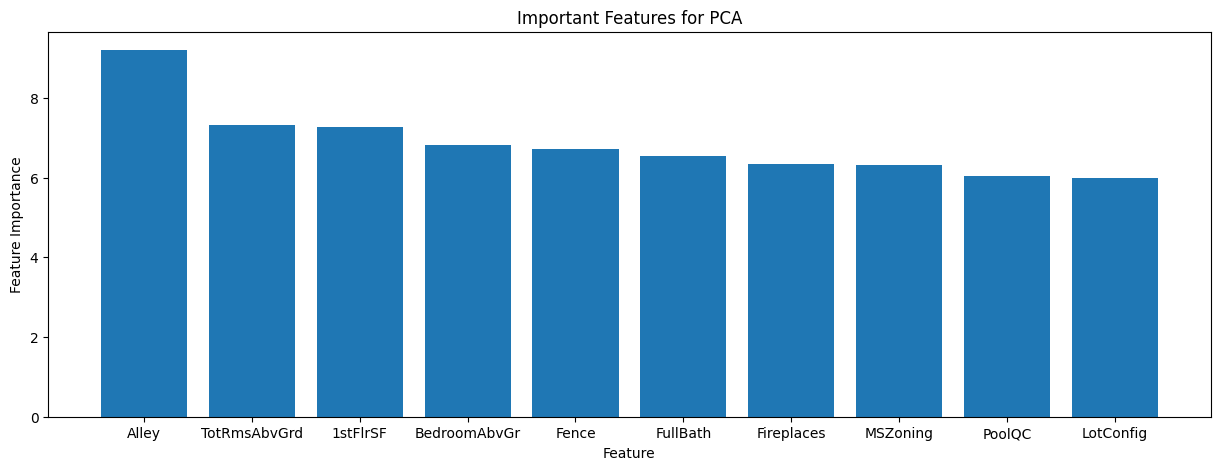

In [20]:
#Important Features for PCA

#Get eigenvectors and eigenvalues
eigenvectors = pca.components_[:, :n_components]
eigenvalues = pca.explained_variance_[:n_components].reshape(-1, 1)

#Calculate feature importance
feature_imp = np.zeros((eigenvectors.shape[0]))
for i in range(0,len(eigenvalues)):
    feature_imp += np.abs(eigenvalues[i] * eigenvectors[:,i])

# Get the indices that would sort the feature_imp in ascending order
sort_ind = np.argsort(feature_imp)

# Select the last 10 indices (corresponding to the largest elements)
largest_feat_ind = sort_ind[-10:]
largest_feat_ind = largest_feat_ind[::-1]  # Reverse order to get largest to smallest

# Get the top 10 elements and their indices
most_imp = feature_imp[largest_feat_ind]

# Get a list of column names corresponding to the selected features
feat_names = list(df_x_encoded.columns[largest_feat_ind])

# Create the bar plot
plt.figure(figsize=(15,5))
plt.bar(range(len(most_imp)), most_imp)
plt.xticks(range(len(feat_names)), feat_names)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Important Features for PCA')
plt.show()

## Numan - Applying ML Techniques

### Random Forest on original and PCA data

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

n_estimators = [100, 200, 300, 400, 500]
max_depth = [3, 4, 5, 6, 7]
max_features = ["sqrt", "log2"]

param_combos = []
oob_scores = []
oob_scores_pca = []


for nm in n_estimators:
    for md in max_depth:
        for mf in max_features:
#             print(nm,md,mf)
            param_combos.append(f"{nm},{md},{mf}")
            
            # Build and train random forest model using base data
            rfr = RandomForestRegressor(n_estimators=nm,
                                       max_depth=md,
                                       max_features=mf,
                                       oob_score=True,
                                       warm_start=True)
            rfr.fit(X_train_scaled, y_train)
            
            # Using out-of-bag (OOB) error for finding the optimal hyperparameters
            oob_scores.append(rfr.oob_score_)
            
            del rfr
            
            # Build and train random forest model using PCA data
            rfr_pca = RandomForestRegressor(n_estimators=nm,
                                       max_depth=md,
                                       max_features=mf,
                                       oob_score=True,
                                       warm_start=True)
            rfr_pca.fit(X_train_pca, y_train)
            
            # Using out-of-bag (OOB) error for finding the optimal hyperparameters
            oob_scores_pca.append(rfr_pca.oob_score_)
            
            del rfr_pca
            
# Obtain index for maximum OOB-score
best_index = oob_scores.index(max(oob_scores))
best_index_pca = oob_scores_pca.index(max(oob_scores_pca))

# Obtain the best hyperparameters associated with that index
rfr_best_nm, rfr_best_md, rfr_best_mf = param_combos[best_index].split(',')
rfr_best_nm_pca, rfr_best_md_pca, rfr_best_mf_pca = param_combos[best_index_pca].split(',')

print(param_combos[best_index].split(','))
print(param_combos[best_index_pca].split(','))

['300', '7', 'log2']
['500', '7', 'sqrt']


#### Training Models with Best Hyperparameters

In [22]:
'''
Best hyperparameters:
['300', '7', 'sqrt']
'''

best_rfr = RandomForestRegressor(n_estimators=int(rfr_best_nm),
                                max_depth=int(rfr_best_md),
                                max_features=rfr_best_mf)
best_rfr.fit(X_train_scaled, y_train)
rfr_y_pred = best_rfr.predict(X_test_scaled)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, rfr_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.1995000467629533


In [23]:
'''
Best hyperparameters:
['300', '3', '0.01']
'''

best_rfr_pca = RandomForestRegressor(n_estimators=int(rfr_best_nm_pca),
                                max_depth=int(rfr_best_md_pca),
                                max_features=rfr_best_mf_pca)
best_rfr_pca.fit(X_train_pca, y_train)
rfr_y_pred_pca = best_rfr_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, rfr_y_pred_pca, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.31277967619307434


#### Graph Feature Importances

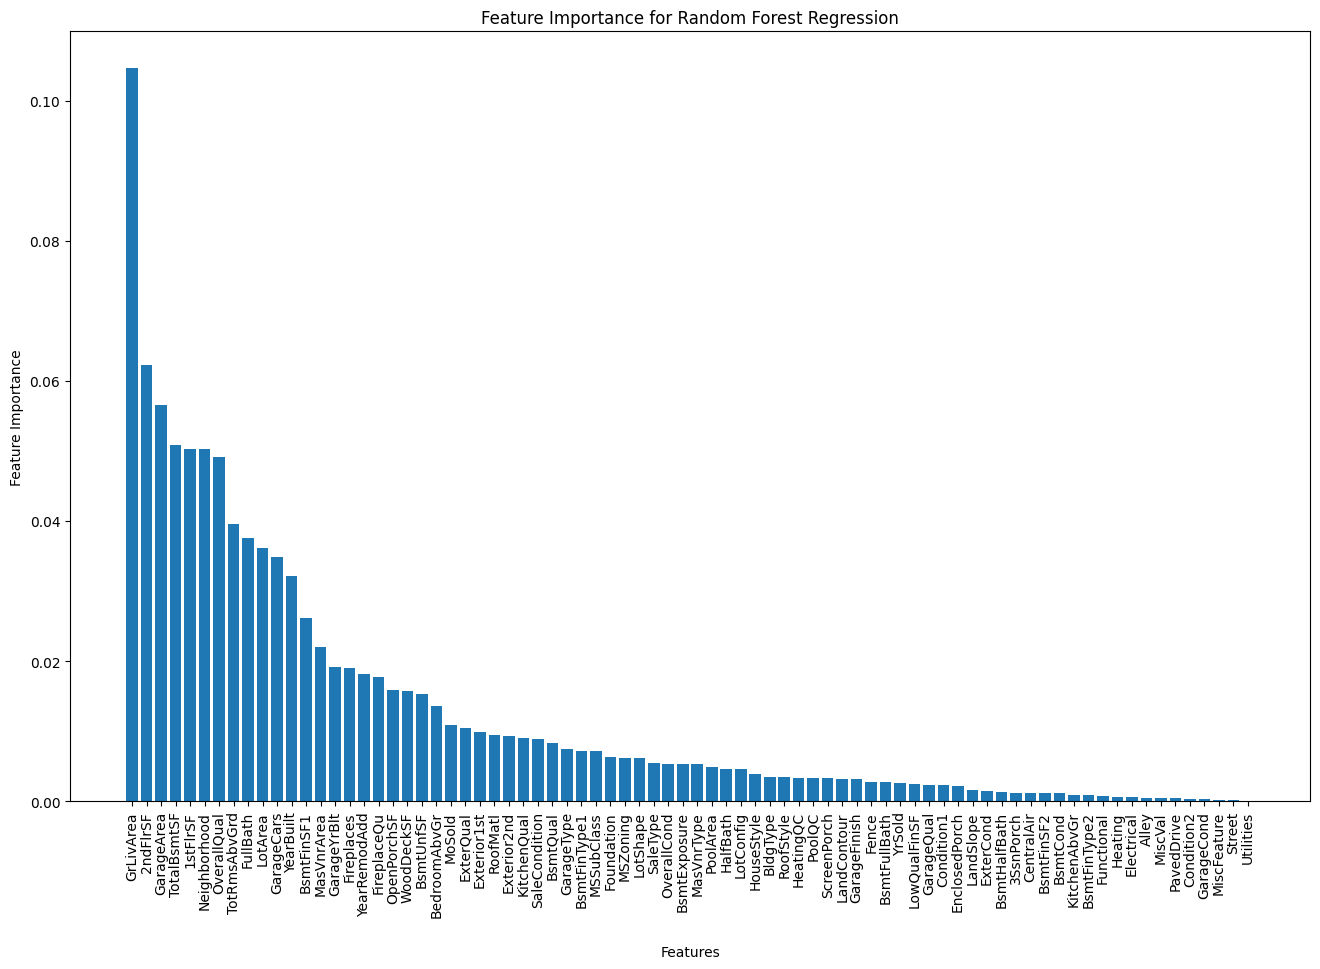

<Figure size 5000x5000 with 0 Axes>

In [24]:
# Organize and sort feature importances in descending order
rfr_tuned_importance = best_rfr.feature_importances_
feature_importance_dict = dict(zip(df_x.columns.to_list(), rfr_tuned_importance))
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Plot the feature importance graph
fig = plt.figure(figsize=(16,10))
plt.bar(sorted_dict.keys(),sorted_dict.values())
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for Random Forest Regression')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

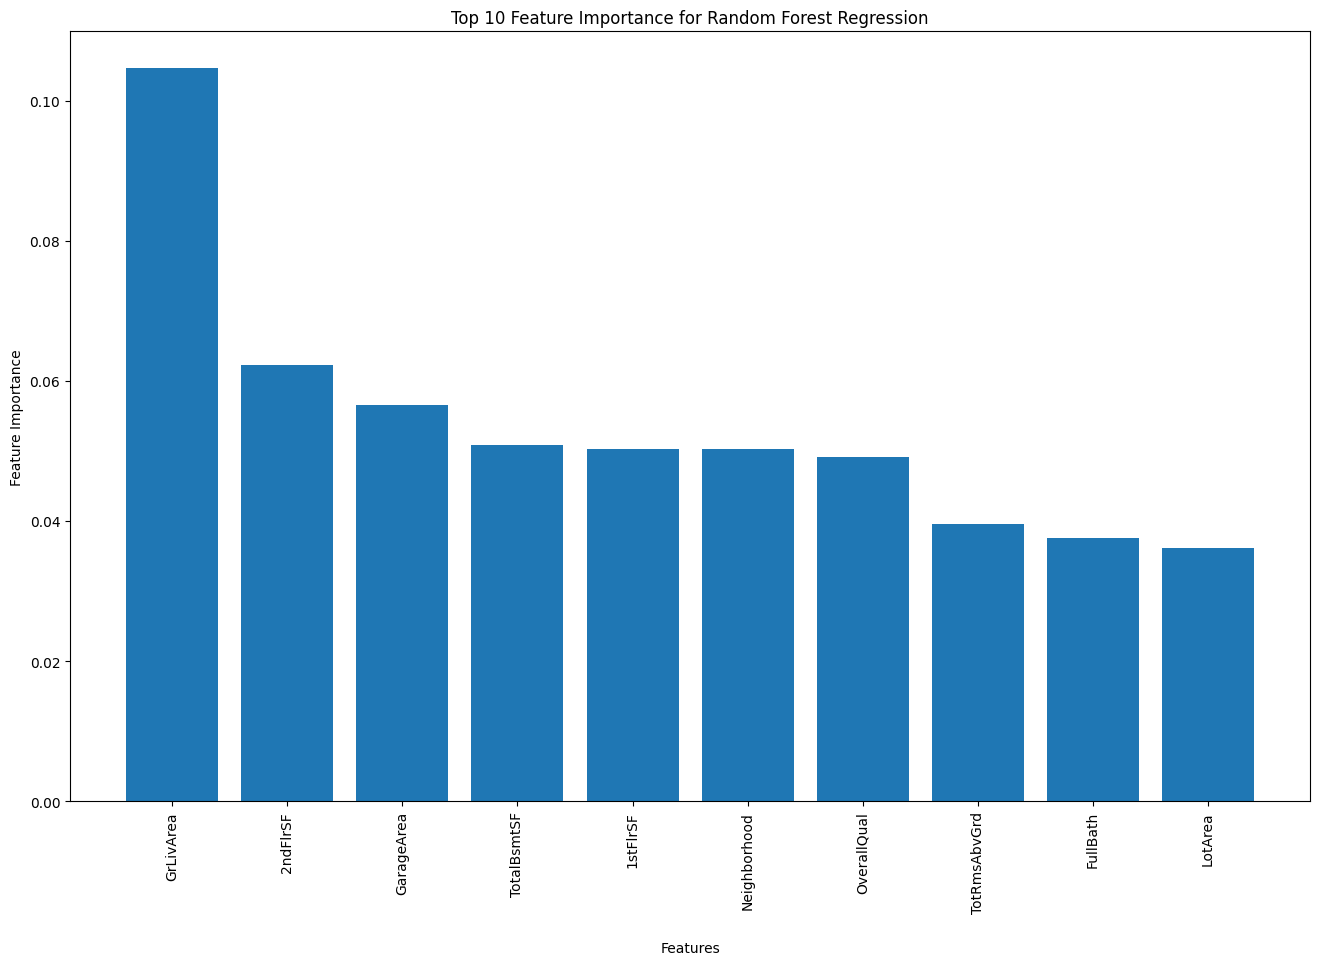

<Figure size 5000x5000 with 0 Axes>

In [25]:
# Organize and sort feature importances in descending order
rfr_tuned_importance = best_rfr.feature_importances_
feature_importance_dict = dict(zip(df_x.columns.to_list(), rfr_tuned_importance))
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:10])

# Plot the feature importance graph
fig = plt.figure(figsize=(16,10))
plt.bar(sorted_dict.keys(),sorted_dict.values())
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Top 10 Feature Importance for Random Forest Regression')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

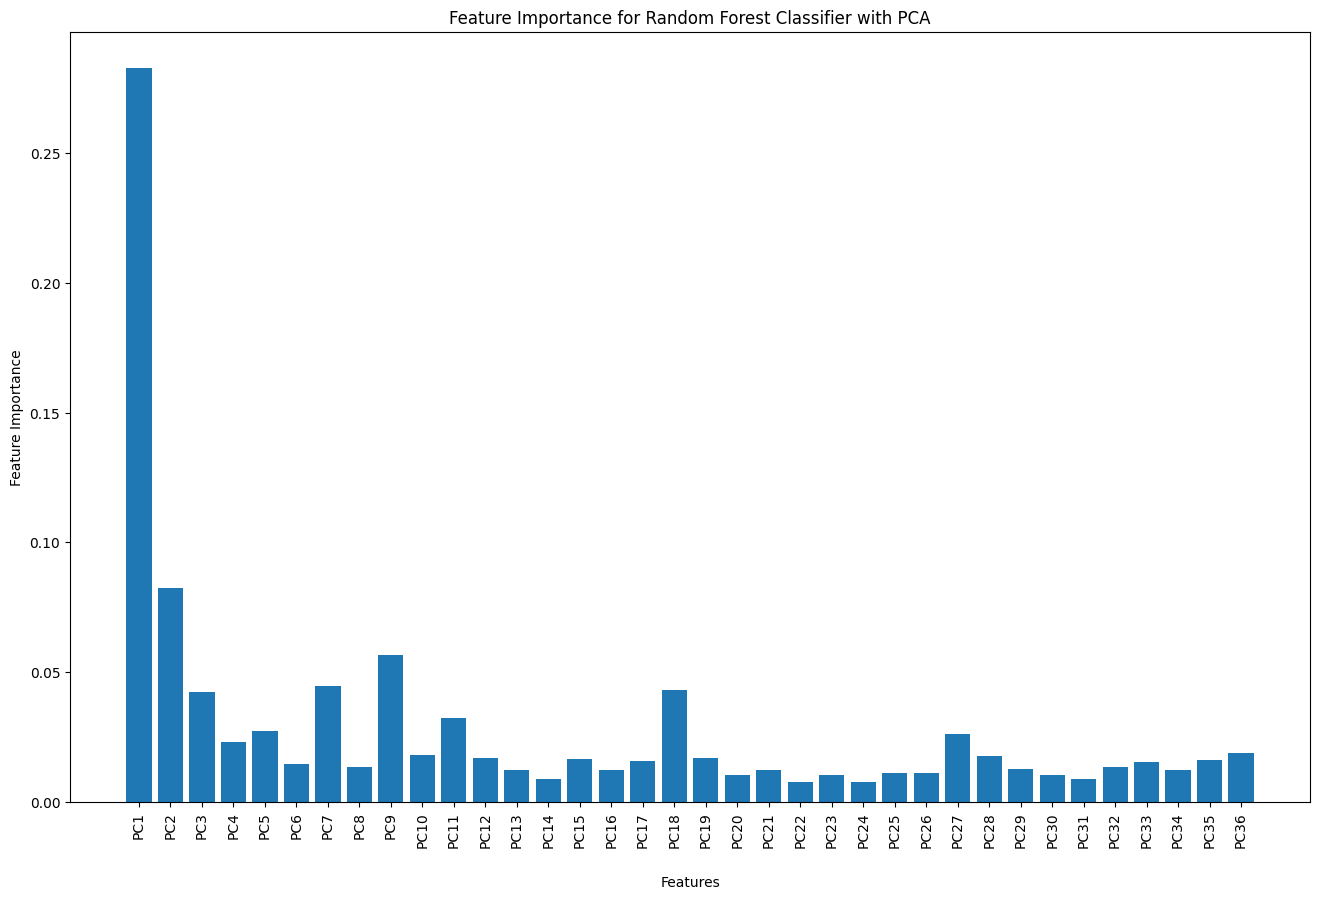

<Figure size 5000x5000 with 0 Axes>

In [26]:
pca_columns=['PC' + str(i + 1) for i in range(n_components)]
rfr_pca_tuned_importance = best_rfr_pca.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,rfr_pca_tuned_importance)
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for Random Forest Classifier with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on original and PCA data

In [27]:
from xgboost import XGBRegressor

n_estimators = [100, 200, 300, 400, 500]
max_depth = [3, 4, 5, 6, 7]
learning_rate = [0.01, 0.1, 0.5]

param_combos = []
rmsle = []
rmsle_pca = []


for nm in n_estimators:
    for md in max_depth:
        for lr in learning_rate:
#             print(nm,md,lr)
            param_combos.append(f"{nm},{md},{lr}")
            
            # Build XGBoost model for base data
            xgbr = XGBRegressor(n_estimators=nm,
                               max_depth=md,
                               learning_rate=lr)
            xgbr.fit(X_train_scaled, y_train)
            
            # Using validation set and RMSLE for finding the optimal hyperparameters
            xgbr_y_pred = xgbr.predict(X_val_scaled)
            rmsle.append(mean_squared_log_error(y_val, xgbr_y_pred, squared=False))
            
            del xgbr

    
            # Build XGBoost model for PCA data
            xgbr_pca = XGBRegressor(n_estimators=nm,
                               max_depth=md,
                               learning_rate=lr)
            xgbr_pca.fit(X_train_pca, y_train)
            
            # Using validation set and RMSLE for finding the optimal hyperparameters
            xgbr_y_pred_pca = xgbr_pca.predict(X_val_pca)
            rmsle_pca.append(mean_squared_log_error(y_val, xgbr_y_pred_pca, squared=False))
            
            del xgbr_pca
            
            
# Obtain index for minimum RMSLE
best_index = rmsle.index(min(rmsle))
best_index_pca = rmsle_pca.index(min(rmsle_pca))

# Obtain the best hyperparameters associated with that index 
xgbr_best_nm, xgbr_best_md, xgbr_best_mf = param_combos[best_index].split(',')
xgbr_best_nm_pca, xgbr_best_md_pca, xgbr_best_mf_pca = param_combos[best_index_pca].split(',')

print(param_combos[best_index].split(','))
print(param_combos[best_index_pca].split(','))

['200', '3', '0.1']
['300', '3', '0.01']


#### Training Models with Best Hyperparameters

In [28]:
'''
Best hyperparameters:
['200', '3', '0.1']
'''

best_xgbr = XGBRegressor(n_estimators=int(xgbr_best_nm),
                       max_depth=int(xgbr_best_md),
                       learning_rate=xgbr_best_mf)
best_xgbr.fit(X_train_scaled, y_train)
xgbr_best_y_pred = best_xgbr.predict(X_test_scaled)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbr_best_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.2007465337426236


In [29]:
'''
Best hyperparameters:
['300', '3', '0.01']
'''

best_xgbr_pca = XGBRegressor(n_estimators=int(xgbr_best_nm_pca),
                       max_depth=int(xgbr_best_md_pca),
                       learning_rate=xgbr_best_mf_pca)
best_xgbr_pca.fit(X_train_pca, y_train)
xgbr_best_pca_y_pred = best_xgbr_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbr_best_pca_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.3556775298320394


#### Graph Feature Importances

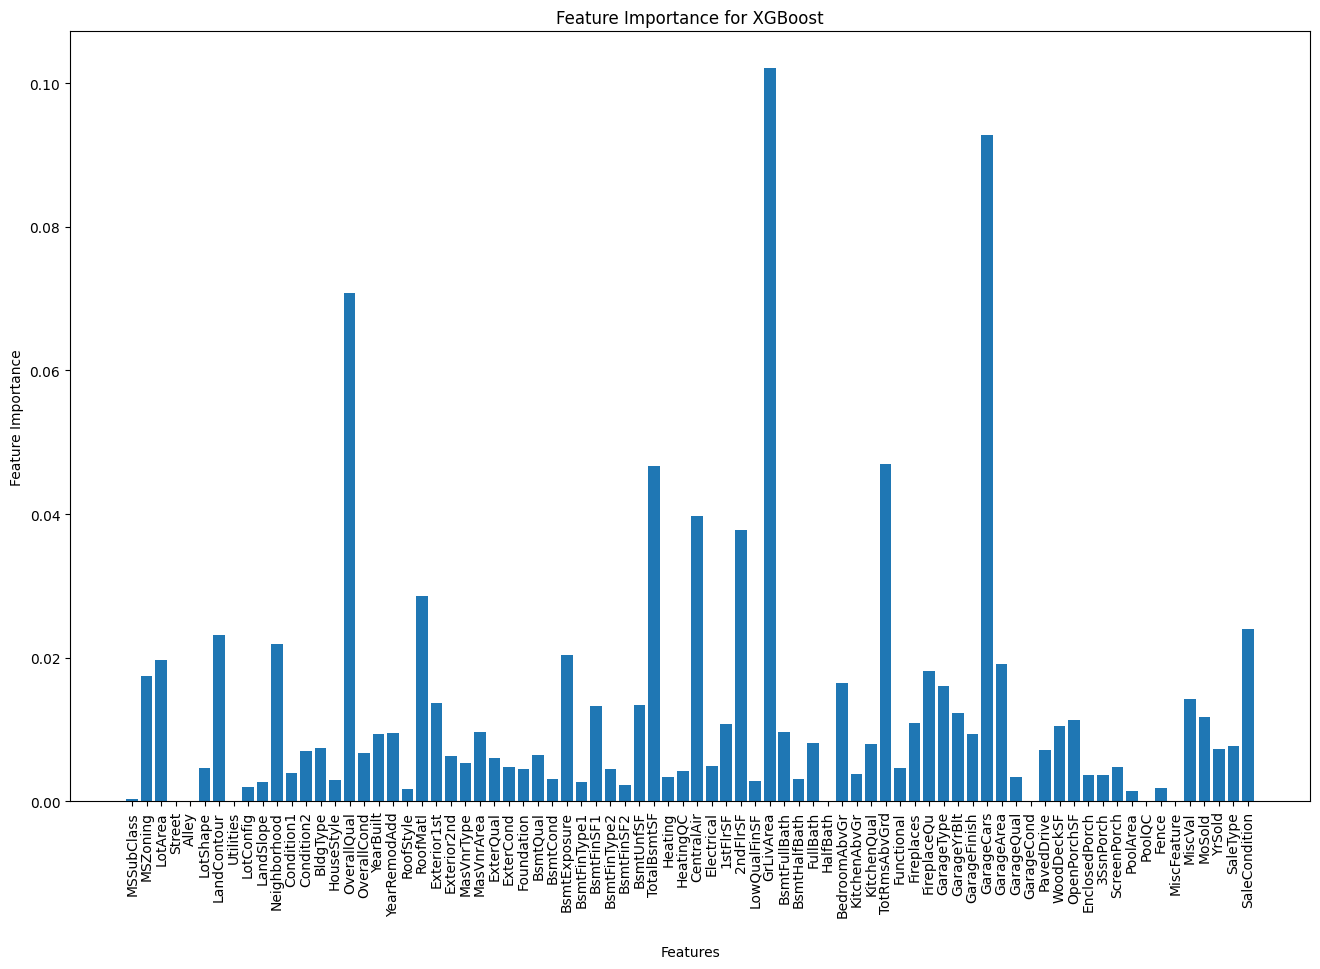

<Figure size 5000x5000 with 0 Axes>

In [30]:
xgb_tuned_importance = best_xgbr.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),xgb_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for XGBoost')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

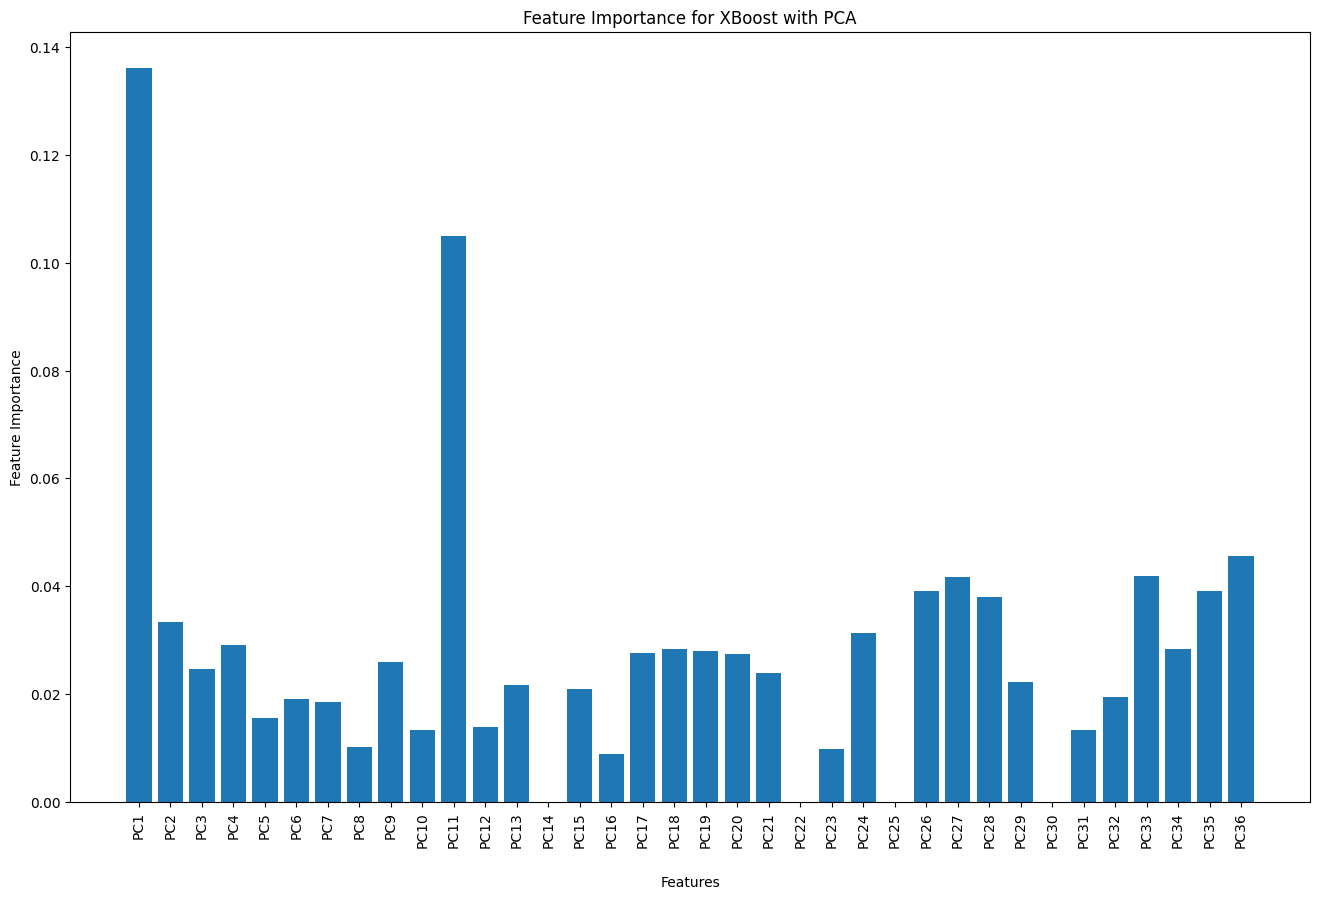

<Figure size 5000x5000 with 0 Axes>

In [31]:
xgb_pca_tuned_importance =best_xgbr_pca.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,xgb_pca_tuned_importance)
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for XBoost with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()